https://github.com/rosinality/glow-pytorch/blob/master/model.py

In [1]:
import torch
from datasets import load_dataset
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.nn as nn
# from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from transformers import AutoImageProcessor, ViTMAEForPreTraining
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy
from math import log, pi, exp

E:\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'E:\anaconda3\envs\pytorch\lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dataset = load_dataset("Isamu136/big-animal-dataset")
train_dataset = dataset["train"]

In [3]:
train_size = 100
train_dataset = train_dataset.shuffle(seed=42).select(range(train_size))

In [4]:
caption_to_label = {}
label_to_caption = {}

caption_set = list(set(train_dataset["caption"]))
for i in range(0, len(caption_set)):
    caption_to_label[caption_set[i]] = i
    label_to_caption[i] = caption_set[i]

In [5]:
image_size = 64
image_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),    # Resize to the target size
    transforms.ToTensor(),          # Convert to a PyTorch tensor
])

class MyCustomDataset(torch.utils.data.Dataset):
    def __init__(self, your_data_here):
        self.data = your_data_here

    def __len__(self):
        return len(self.data['image'])

    def __getitem__(self, idx):
        return {
            'image': image_transform(self.data['image'][idx]),
            'caption': self.data['caption'][idx],
            'label': caption_to_label[self.data['caption'][idx]],
        }
    
batch_size = 32
my_train_dataset = MyCustomDataset(train_dataset)
dataloader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [32]:
class ActNorm(nn.Module):
    def __init__(self, in_channels):
        super(ActNorm, self).__init__()
        self.loc = nn.Parameter(torch.zeros(1, in_channels, 1, 1))
        self.scale = nn.Parameter(torch.zeros(1, in_channels, 1, 1))
        self.initialized = False
        
    def initialize(self, input):
        mean = torch.mean(input, dim=(0, 2, 3), keepdim=True)
        #tensor([[[[0.5439]], [[0.5019]], [[0.5298]]]])
        std = torch.std(input, dim=(0, 2, 3), keepdim=True)
    
        self.loc.data.copy_(-mean)
        self.scale.data.copy_(1 / (std + 1e-6))
        
    def forward(self, input):
        if not self.initialized:
            self.initialized = True
            self.initialize(input)
        
        # the log(|abc|) = log(|a|) + log(|b|) + log(|c|)
        logdet = input.shape[2] * input.shape[3] * torch.log(torch.abs(self.scale)).sum()
        logdet = logdet.unsqueeze(0).repeat(input.shape[0])
        
        return (input / self.scale) - self.loc, logdet
        
    def reverse(self, input):
        return self.scale * (input + self.loc)
    
    
class InConv2d(nn.Module):
    def __init__(self, in_channels):
        super(InConv2d, self).__init__()
        self.eye = torch.eye(in_channels)
        
        kernel = np.random.randn(in_channels, in_channels)
        # create a orthogonal matrix. A orthogonal matrix must be invertible
        q, r = scipy.linalg.qr(kernel)  # QR factorization : Q: orthogonal. R: upper triangular        
        p, l, u = scipy.linalg.lu(q.astype(np.float32))
        s = np.diag(u)
        u = np.triu(u, 1)
        
        p = torch.from_numpy(p)
        l = torch.from_numpy(l)
        u = torch.from_numpy(u)
        s = torch.from_numpy(s)
        
        self.p = nn.Parameter(p, requires_grad=False)
        self.l = nn.Parameter(l, requires_grad=True)
        self.u = nn.Parameter(u, requires_grad=True)
        self.s = nn.Parameter(s, requires_grad=True)
        
    def getWeight(self):
        return self.p @ (torch.tril(self.l, 1) + self.eye) @ (torch.triu(self.u, 1) + torch.diag(self.s))
        
    def forward(self, input):
        weight = self.getWeight().unsqueeze(2).unsqueeze(3)
        output = F.conv2d(input, weight)
        
        logdet = input.shape[2] * input.shape[3] * torch.log(torch.abs(self.s)).sum()
        logdet = logdet.unsqueeze(0).repeat(input.shape[0])
        
        return output, logdet
        
    def reverse(self, input):
        inv_weight = self.getWeight().inverse().unsqueeze(2).unsqueeze(3)
        return F.conv2d(input, inv_weight)
    
    
class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super(ZeroConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=0)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))

    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)

        return out
    
    
class AffineCoupling(nn.Module):
    def __init__(self, in_channels, filter_size=512):
        super(AffineCoupling, self).__init__()
                
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels//2, filter_size, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(),
            ZeroConv2d(filter_size, in_channels, padding=1)
        )
        
        self.layers[0].weight.data.normal_(0, 0.05)
        self.layers[0].bias.data.normal_(0, 0.05)
        self.layers[2].weight.data.normal_(0, 0.05)
        self.layers[2].bias.data.normal_(0, 0.05)
        
    def forward(self, input):
        # we will make in_channel divisible by 4 in the Block part
        xa, xb= input.chunk(2, 1)
            
        log_s, t = self.layers(xb).chunk(2, 1)
        s = F.sigmoid(log_s + 2)
#         s = torch.exp(log_s)
        ya = (xa + t) * s
        yb = xb
        output = torch.cat([ya, yb], dim=1)
        
        
        # logdet
        logdet = torch.log(torch.abs(s)).sum(1).sum(1).sum(1) # preserve batch
        
        
        return output, logdet
    
    def reverse(self, input):
        ya, yb= input.chunk(2, 1)
            
        log_s, t = self.layers(yb).chunk(2, 1)
        s = F.sigmoid(log_s + 2)
#         s = torch.exp(log_s)
        xa = ya / s - t
        xb = yb
        output = torch.cat([xa, xb], dim=1)        
        
        return output
        
    
class Flow(nn.Module):
    def __init__(self, in_channels):
        super(Flow, self).__init__()
        self.actnorm = ActNorm(in_channels)
        self.inconv2d = InConv2d(in_channels)
        self.affinecoupling = AffineCoupling(in_channels)
        
    def forward(self, input):
        out, det1 = self.actnorm(input)
        out, det2 = self.inconv2d(out)
        out, det3 = self.affinecoupling(out)
        
        return out, det1 + det2 + det3
    
    def reverse(self, input):
        out = self.actnorm.reverse(input)
        out = self.inconv2d.reverse(out)
        out = self.affinecoupling.reverse(out)
        return out
    
    
class Block(nn.Module):
    def __init__(self, in_channels, n_flow, split=True):
        super(Block, self).__init__()
        
        self.split = split
        
        squeeze_dim = in_channels * 4
        
        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim))
            
        if split:
            self.prior = ZeroConv2d(in_channels * 2, in_channels * 4)  # For learning the distribution of p_\theta with model output
        else:
            self.prior = ZeroConv2d(in_channels * 4, in_channels * 8)  # For learning the distribution of p_\theta with 0 
                
    def gaussian_log_p(self, x, mean, log_std):
        return -0.5 * log(2 * pi) - log_std - 0.5 * (x - mean) ** 2 / torch.exp(2 * log_std)
    
    def gaussian_sample(self, eps, mean, log_std):
        return mean + torch.exp(log_std) * eps
        
    def forward(self, input):
        bs, in_channels, height, width = input.shape
        # Enlarge in_channel so that it will be divisible by 4 in the AffineCoupling
        squeezed_input = input.view(bs, in_channels, height//2, 2, width//2, 2)
        squeezed_input = squeezed_input.permute(0, 1, 3, 5, 2, 4)
        output = squeezed_input.contiguous().view(bs, in_channels * 4, height//2, width//2)
#         output = squeezed_input.view(bs, in_channels * 4, height//2, width//2)
        
        total_logdet = 0
        for flow in self.flows:
            output, logdet = flow(output)
            total_logdet = total_logdet + logdet
            
        if self.split:
            # Output will be fed to be next layer
            # new_z will be concatenated to reverse output to produce image
            # into a linear layer to construct the prior of p_\theta.
            # We use Output as parameters of the distribution p_\theta(z). Thus, the likelihood of z is maximized. 
            output, new_z = output.chunk(2, 1)
            mean, log_std = self.prior(output).chunk(2, 1)
            log_p_z = self.gaussian_log_p(new_z, mean, log_std)
            log_p_z = log_p_z.sum(1).sum(1).sum(1)
        else:
            # When there is no z to split, we directly maximize the likelihood of Output
            zero = torch.zeros_like(output)
            mean, log_std = self.prior(zero).chunk(2, 1)
            log_p_z = self.gaussian_log_p(output, mean, log_std)
            log_p_z = log_p_z.sum(1).sum(1).sum(1)
            new_z = output
        
        return output, total_logdet, new_z, log_p_z
        
    def reverse(self, input, eps=None):
        if self.split:
            mean, log_std = self.prior(input).chunk(2, 1)
            z = self.gaussian_sample(eps, mean, log_std)  # use reparameterization trick to sample
            output = torch.cat([input, z], dim=1)
        else:
            zero = torch.zeros_like(input)
            mean, log_std = self.prior(zero).chunk(2, 1)
            output = self.gaussian_sample(eps, mean, log_std)
        
        for flow in self.flows[::-1]:
            output = flow.reverse(output)
    
        bs, in_channels, height, width = output.shape
        unsqueezed_output = output.view(bs, in_channels // 4, 2, 2, height, width)
        unsqueezed_output = unsqueezed_output.permute(0, 1, 4, 2, 5, 3)
        unsqueezed_output = unsqueezed_output.contiguous().view(bs, in_channels // 4, height*2, width*2)
#         unsqueezed_output = unsqueezed_output.view(bs, in_channels // 4, height*2, width*2)
        
        return unsqueezed_output


class Glow(nn.Module):
    def __init__(self, in_channels, n_flow, n_block):
        super(Glow, self).__init__()
        self.blocks = nn.ModuleList()
        
        # 3   ->  12  ->   6, 6   ->   6
        # 6   ->  24  ->  12, 12  ->  12
        # 12  ->  48  ->  48, 48  ->  48
        
        n_channels = in_channels
        for i in range(0, n_block-1):
            self.blocks.append(Block(n_channels, n_flow, split=True))
            n_channels *= 2
        self.blocks.append(Block(n_channels, n_flow, split=False))
        
    def forward(self, input):
        log_p_total = 0
        logdet_total = 0
        output = input
        z_outs = []
        
        for block in self.blocks:
            output, total_logdet_, new_z, log_p_z = block(output)
            log_p_total += log_p_z
            logdet_total += total_logdet_
            z_outs.append(new_z)
            
        return log_p_total, logdet_total, z_outs
    
    def reverse(self, z_outs):
        output = input
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0:
                output = block.reverse(z_outs[-1], z_outs[-1])
            else:
                output = block.reverse(output, z_outs[-i-1])
                
        return output

In [47]:
n_bits = 5
n_bins = 2.0 ** n_bits

n_channels = 3
n_flow = 32
n_block = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Glow(n_channels, n_flow, n_block).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [30]:
torch.cuda.is_available()

False

In [48]:
model.train()

# For generating images, we need to make a random z
def calc_z_shapes(n_channel, input_size, n_flow, n_block):
    z_shapes = []
    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2
        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))
    return z_shapes

def calc_loss(log_p, logdet, image_size, n_bins):
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * n_pixel)).mean(),
        (log_p / (log(2) * n_pixel)).mean(),
        (logdet / (log(2) * n_pixel)).mean(),
    )


iters = 100
loss_list = []

steps = 0
for iter in tqdm(range(iters)):
    iter_loss = 0
    for data_batch in dataloader:
        images = data_batch["image"].to(device)
        images = torch.floor(images * 255 / 2 ** (8 - n_bits)) / n_bins - 0.5
        
        if i == 0:
            with torch.no_grad():
                log_p, logdet, z_outs = model(images + torch.rand_like(images) / n_bins)
                continue
        else:
            log_p, logdet, z_outs = model(images + torch.rand_like(images) / n_bins)
        
        logdet = logdet.mean()
        loss, log_p, log_det = calc_loss(log_p, logdet, image_size, n_bins)
        iter_loss += loss.item()

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1
        
        
        
        if steps % 100 == 0:
            model.eval()
#             generate_image()
            model.train()
    loss_list.append(iter_loss)

  0%|                                                                                          | 0/100 [00:52<?, ?it/s]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

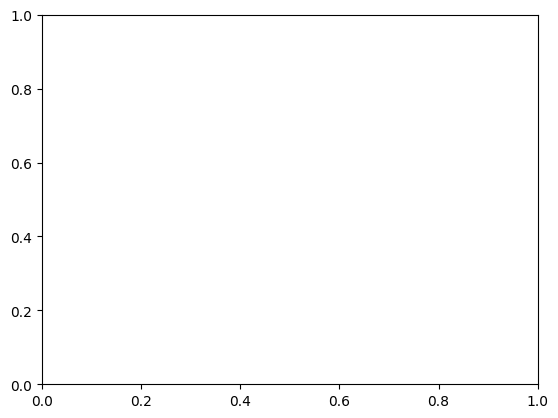

In [41]:
plt.plot(range(iters), loss_list)

(4, 64, 64, 3)
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0

<Figure size 640x480 with 0 Axes>

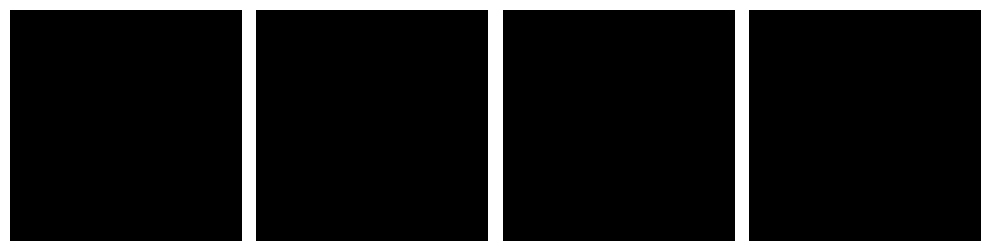

In [39]:
def generate_image():
    z_sample = []
    z_shapes = calc_z_shapes(3, image_size, n_flow, n_block)
    for z in z_shapes:
        z_new = torch.randn(4, *z) * 98098
        z_sample.append(z_new.to(device))
    with torch.no_grad():
        generated_images = model.reverse(z_sample).permute(0, 2, 3, 1).cpu().data.numpy()

    print(generated_images.shape)
    print(generated_images)
    plt.figure(steps)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(4):
        ax = axes[i]
        ax.imshow(generated_images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
generate_image()